# testing template smoothing

When generating up/down morphing templates, the effects of limited statistics can effect how accurately the varied templates represent the underlying change in the distribution governing the sampling of events.  One way of mitigating the impact of the statistical variations is to smooth the varied templates.  This is typically complicated by the fact the the underlying pdf and its parameterization is unknown so we must resort to non-parametric methods as a representation of the unknown distribution.  In this notebook, I will use a toy example to test the performance of a few common methods.

In [18]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from skhep.modeling import bayesian_blocks
import scripts.plot_tools as pt
import scripts.fit_helpers as fh
import scripts.template_maker as tm
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 45505,
  "iopub_port": 48275,
  "stdin_port": 53569,
  "control_port": 35625,
  "hb_port": 47807,
  "ip": "127.0.0.1",
  "key": "19147c15-b04a8ac6e50437dbebf76b4a",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-e87c83ac-cd14-473d-80de-24abce96b373.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


## a toy example

To begin we consider a toy example to explore some of the characteristics of template morphing schemes.  The toy model is generated from an arbitrary, single parameter function  which can be varied to generate morphing templates which will then be smoothed.

In [19]:
# generate toy data and variations
def func(x, a=1):
    u = a*x
    return (a/2) * u**2 * np.exp(-u)

def func_int(x1, x2, a=1):
    u1, u2 = a*x1, a*x2
    int_a = (0.5*u1**2 + u1 + 1) * np.exp(-u1)
    int_b = (0.5*u2**2 + u2 + 1) * np.exp(-u2)
    return (int_a - int_b)  

xmin, xmax = 0, 21
scale = 0.5

rnum = np.random.rand(2, int(1e6))
rnum[0] *= (xmax - xmin)
f_nom = func(rnum[0], scale)
mask_nom = rnum[1] < f_nom
toy_data_nom = rnum[0][mask_nom]
#toy_data_up = 1.02*toy_data_nom
#toy_data_down = 0.98*toy_data_nom

rnum = np.random.rand(2, int(5e5))
rnum[0] *= (xmax - xmin)
f_up = func(rnum[0], 1.02*scale)
mask_up = rnum[1] < f_up
toy_data_up = rnum[0][mask_up]

rnum = np.random.rand(2, int(5e5))
rnum[0] *= (xmax - xmin)
f_down = func(rnum[0], 0.98*scale)
mask_down = rnum[1] < f_down
toy_data_down = rnum[0][mask_down]
print(toy_data_nom.size, toy_data_up.size, toy_data_down.size)

47766 23991 23809


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: Use

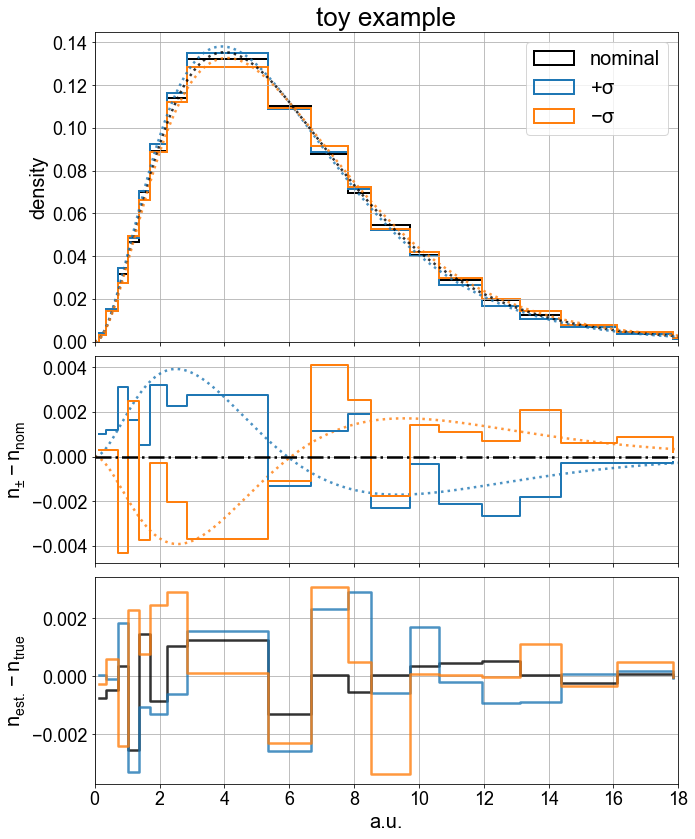

In [20]:
# plot the function and its up and down variants
fig, axes = plt.subplots(3, 1, figsize=(10, 12), facecolor='white', sharex=True, gridspec_kw={'height_ratios': [3, 2, 2]})
fig.subplots_adjust(hspace=0)

ax = axes[0]
x = np.linspace(xmin, xmax, 1001)
bins = bayesian_blocks(toy_data_nom[:int(3e4)], p0=0.01)
#bins = np.linspace(xmin, xmax, 50)
dbins = bins[1:] - bins[:-1]
#bins = np.linspace(xmin, xmax, 21)

ax.plot(x, func(x, scale), 'k:', alpha=0.8)
ax.plot(x, func(x, 1.02*scale), 'C0:', alpha=0.8)
ax.plot(x, func(x, 0.98*scale), 'C1:', alpha=0.8)

h_nom, _, _ = ax.hist(toy_data_nom, bins, histtype='step', linewidth=2, color='k', density=True, label='nominal')
h_up, _, _ = ax.hist(toy_data_up, bins, histtype='step', linewidth=2, color='C0', density=True, label=r'$+\sigma$')
h_down, _, _ = ax.hist(toy_data_down, bins, histtype='step', linewidth=2, color='C1', density=True, label=r'$-\sigma$')

ax.set_ylabel('density')
ax.set_title('toy example')
ax.legend()
ax.grid()

ax = axes[1]
ax.plot(x, (func(x, 1.02*scale) - func(x, scale)), 'C0:', alpha=0.8)
ax.plot(x, (func(x, 0.98*scale) - func(x, scale)), 'C1:', alpha=0.8)

ax.plot(bins[:-1], h_up - h_nom, 'C0-', linewidth=2, drawstyle='steps-post')
ax.plot(bins[:-1], h_down - h_nom, 'C1-', linewidth=2, drawstyle='steps-post')
ax.plot([0, 20], [0, 0], 'k-.')
ax.set_ylabel(r'$n_{\pm} - n_{nom}$')
ax.grid()

ax = axes[2]
h_nom_true = np.array([func_int(x1, x2, scale)/(x2 - x1) for x1, x2 in zip(bins[:-1], bins[1:])])
h_up_true = np.array([func_int(x1, x2, 1.02*scale)/(x2 - x1) for x1, x2 in zip(bins[:-1], bins[1:])])
h_down_true = np.array([func_int(x1, x2, 0.98*scale)/(x2 - x1) for x1, x2 in zip(bins[:-1], bins[1:])])
ax.plot(bins[:-1], h_nom - h_nom_true, 'k', alpha=0.8, drawstyle='steps-post')
ax.plot(bins[:-1], h_up - h_up_true, 'C0', alpha=0.8, drawstyle='steps-post')
ax.plot(bins[:-1], h_down - h_down_true, 'C1', alpha=0.8, drawstyle='steps-post')

ax.set_xlim(0, 18)
#ax.set_ylim(0.5, 1.5)
ax.set_xlabel('a.u.')
ax.set_ylabel(r'$n_{est.} - n_{true}$')
ax.grid()

plt.tight_layout(h_pad=0.)
plt.savefig('plots/stats/toy_example_emorph.pdf')
plt.show()

## KDE

In this approach, a KDE is used to estimate the density (instead of the histogram) for the nominal and up/down variations.  The morphing templates are then generated from the KDE.  As with the following approach (LOWESS regression), the complication is picking the correct value for the _bandwidth_ parameter. In this case, the smoothing is done at the level of the raw data.

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


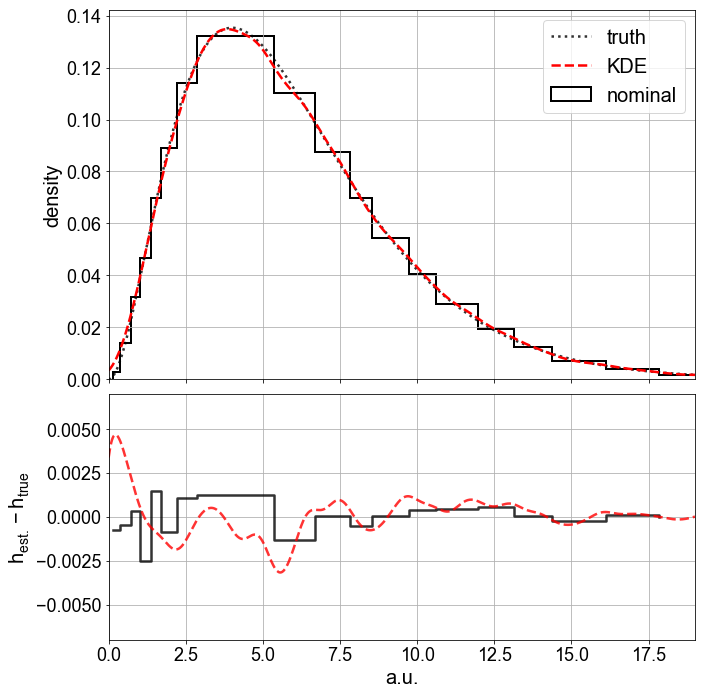

In [21]:
# Carry out KDE of nominal and varied templates

fig, axes = plt.subplots(2, 1, figsize=(10, 10), facecolor='white', sharex=True, gridspec_kw={'height_ratios': [3, 2]})

ax = axes[0]
norm = toy_data_nom.size
ax.plot(x, func(x, scale), 'k:', alpha=0.8, label='truth')
h_nom, _, _ = ax.hist(toy_data_nom, bins, histtype='step', linewidth=2, color='k', density=True, label='nominal')

# get kernel and plot for several points
from scipy.stats import gaussian_kde
kernel = gaussian_kde(toy_data_nom, bw_method='scott')
h_smooth = kernel(x)
ax.plot(x, h_smooth, 'r--', label='KDE')

ax.set_ylabel('density')
#ax.set_title('toy example')
ax.legend()
ax.grid()

ax = axes[1]

ax.plot(bins[:-1], h_nom - h_nom_true, 'k', alpha=0.8, drawstyle='steps-post')
dsmooth = h_smooth - func(x, scale)
ax.plot(x, dsmooth, 'r--', alpha=0.8)

ax.set_xlim(0, 19)
y_max = np.max(np.abs(dsmooth))
ax.set_ylim(-1.5*y_max, 1.5*y_max)
ax.set_xlabel('a.u.')
ax.set_ylabel(r'$h_{est.} - h_{true}$')
ax.grid()

plt.tight_layout(h_pad=0.)
plt.savefig('plots/stats/toy_example_emorph.pdf')
plt.show()
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: Use

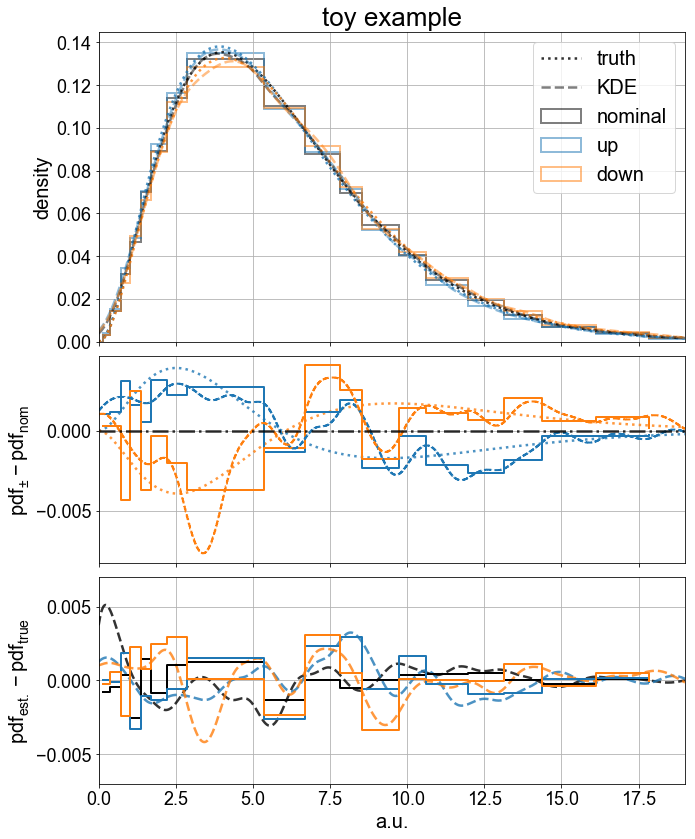

In [22]:
# Carry out KDE of nominal and varied templates

fig, axes = plt.subplots(3, 1, figsize=(10, 12), facecolor='white', sharex=True, gridspec_kw={'height_ratios': [3, 2, 2]})

ax = axes[0]
ax.plot(x, func(x, scale), 'k:', alpha=0.8, label='truth')
ax.plot(x, func(x, 1.02*scale), 'C0:', alpha=0.8, label='_nolegend_')
ax.plot(x, func(x, 0.98*scale), 'C1:', alpha=0.8, label='_nolegend_')
h_nom, _, _ = ax.hist(toy_data_nom, bins, histtype='step', linewidth=2, color='k', alpha=0.5, density=True, label='nominal')
h_up, _, _ = ax.hist(toy_data_up, bins, histtype='step', linewidth=2, color='C0', alpha=0.5, density=True, label='up')
h_down, _, _ = ax.hist(toy_data_down, bins, histtype='step', linewidth=2, color='C1', alpha=0.5, density=True, label='down')

# get kernel and plot for several points
from scipy.stats import gaussian_kde
kernel = gaussian_kde(toy_data_nom, bw_method='silverman')
h_smooth_nom = kernel(x)
ax.plot(x, h_smooth_nom, 'k--', label='KDE', alpha=0.5)

kernel = gaussian_kde(toy_data_up, bw_method='silverman')
h_smooth_up = kernel(x)
ax.plot(x, h_smooth_up, 'C0--', label='_nolegend_', alpha=0.5)

kernel = gaussian_kde(toy_data_down, bw_method='silverman')
h_smooth_down = kernel(x)
ax.plot(x, h_smooth_down, 'C1--', label='_nolegend_', alpha=0.5)

ax.set_ylabel('density')
ax.set_title('toy example')
ax.legend()
ax.grid()

ax = axes[1]
#true
ax.plot(x, func(x, 1.02*scale) - func(x, scale), 'C0:', alpha=0.8)
ax.plot(x, func(x, 0.98*scale) - func(x, scale), 'C1:', alpha=0.8)
# hists
ax.plot(bins[:-1], h_up - h_nom, 'C0-', linewidth=2, drawstyle='steps-post') 
ax.plot(bins[:-1], h_down - h_nom, 'C1-', linewidth=2, drawstyle='steps-post')
# KDE
ax.plot(x, h_smooth_up - h_smooth_nom, 'C0--', linewidth=2, drawstyle='steps-post') 
ax.plot(x, h_smooth_down - h_smooth_nom, 'C1--', linewidth=2, drawstyle='steps-post')

ax.plot([0, 20], [0, 0], 'k-.', alpha=0.8)
ax.set_ylabel(r'$pdf_{\pm} - pdf_{nom}$')
ax.grid()

ax = axes[2]
dsmooth_nom = h_smooth_nom - func(x, scale)
ax.plot(x, dsmooth_nom, 'k--', alpha=0.8)
dsmooth_up = (h_smooth_up - h_smooth_nom) - (func(x, 1.02*scale) - func(x, scale))
ax.plot(x, dsmooth_up, 'C0--', alpha=0.8)
dsmooth_down = (h_smooth_down - h_smooth_nom) - (func(x, 0.98*scale) - func(x, scale))
#dsmooth_down = h_smooth_down - func(x, 1.02*scale)
ax.plot(x, dsmooth_down, 'C1--', alpha=0.8)

ax.plot(bins[:-1], h_nom - h_nom_true, 'k', linewidth=2., alpha=1., drawstyle='steps-post')
ax.plot(bins[:-1], h_up - h_up_true, 'C0', linewidth=2., alpha=1., drawstyle='steps-post')
ax.plot(bins[:-1], h_down - h_down_true, 'C1', linewidth=2., alpha=1., drawstyle='steps-post')

ax.set_xlim(0, 19)
y_max = np.max(np.abs(dsmooth))
ax.set_ylim(-1.5*y_max, 1.5*y_max)
ax.set_xlabel('a.u.')
ax.set_ylabel(r'$pdf_{est.} - pdf_{true}$')
ax.grid()

plt.tight_layout(h_pad=0.)
plt.savefig('plots/stats/toy_example_emorph.pdf')
plt.show()

## LOWESS 

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: Use

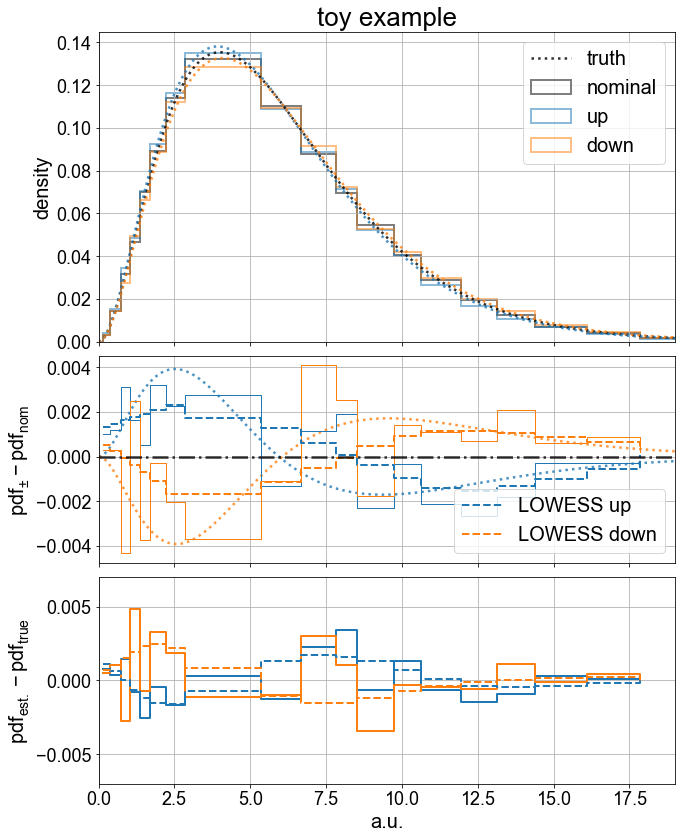

In [23]:
# Carry out LOWESS on difference of templates

fig, axes = plt.subplots(3, 1, figsize=(10, 12), facecolor='white', sharex=True, gridspec_kw={'height_ratios': [3, 2, 2]})

ax = axes[0]
ax.plot(x, func(x, scale), 'k:', alpha=0.8, label='truth')
ax.plot(x, func(x, 1.02*scale), 'C0:', alpha=0.8, label='_nolegend_')
ax.plot(x, func(x, 0.98*scale), 'C1:', alpha=0.8, label='_nolegend_')
h_nom, _, _ = ax.hist(toy_data_nom, bins, histtype='step', linewidth=2, color='k', alpha=0.5, density=True, label='nominal')
h_up, _, _ = ax.hist(toy_data_up, bins, histtype='step', linewidth=2, color='C0', alpha=0.5, density=True, label='up')
h_down, _, _ = ax.hist(toy_data_down, bins, histtype='step', linewidth=2, color='C1', alpha=0.5, density=True, label='down')

ax.set_ylabel('density')
ax.set_title('toy example')
ax.legend()
ax.grid()

ax = axes[1]
ax.plot(x, func(x, 1.02*scale) - func(x, scale), 'C0:', alpha=0.8)
ax.plot(x, func(x, 0.98*scale) - func(x, scale), 'C1:', alpha=0.8)

ax.plot(bins[:-1], h_up - h_nom, 'C0-', linewidth=1, drawstyle='steps-post')
ax.plot(bins[:-1], h_down - h_nom, 'C1-', linewidth=1, drawstyle='steps-post')

# do LOWESS smoothing here
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

#fine_bins = np.linspace(bins[0], bins[-1], 40)
#fine_bins_mid = (fine_bins[1:] + fine_bins[:-1])/2
#h_nom_fine, _ = np.histogram(toy_data_nom, fine_bins, density=True)
#h_up_fine, _ = np.histogram(toy_data_up, fine_bins, density=True)
#h_down_fine, _ = np.histogram(toy_data_down, fine_bins, density=True)
#
#d_up, d_down = h_up_fine - h_nom_fine, h_down_fine - h_nom_fine
#d_smooth_up   = lowess(d_up, fine_bins_mid, frac=0.2, return_sorted=False)
#d_smooth_down = lowess(d_down, fine_bins_mid, frac=0.2, return_sorted=False)
#ax.plot(fine_bins[:-1], d_smooth_up, 'C0--', linewidth=2, drawstyle='steps-post', label='LOWESS up')
#ax.plot(fine_bins[:-1], d_smooth_down, 'C1--', linewidth=2, drawstyle='steps-post', label='LOWESS down')

d_up, d_down = h_up - h_nom, h_down - h_nom
bins_mid = (bins[:-1] + bins[1:])/2
d_smooth_up   = lowess(d_up, bins_mid, frac=0.5, return_sorted=False)
d_smooth_down = lowess(d_down, bins_mid, frac=0.5, return_sorted=False)
ax.plot(bins[:-1], d_smooth_up, 'C0--', linewidth=2, drawstyle='steps-post', label='LOWESS up')
ax.plot(bins[:-1], d_smooth_down, 'C1--', linewidth=2, drawstyle='steps-post', label='LOWESS down')
ax.plot([0, 20], [0, 0], 'k-.', alpha=0.8)
ax.set_ylabel(r'$pdf_{\pm} - pdf_{nom}$')
ax.legend()
ax.grid()

ax = axes[2]
#ax.plot(bins[:-1], h_nom - h_nom_true, 'k', linewidth=2., alpha=1., drawstyle='steps-post')
ax.plot(bins[:-1], (h_up - h_nom) - (h_up_true - h_nom_true), 'C0', linewidth=2., alpha=1., drawstyle='steps-post')
ax.plot(bins[:-1], (h_down - h_nom) - (h_down_true - h_nom_true), 'C1', linewidth=2., alpha=1., drawstyle='steps-post')

#ax.plot(fine_bins[:-1], d_smooth_up - (func(fine_bins_mid, 1.02*scale) - func(fine_bins_mid, scale)), 'C0--', linewidth=2., alpha=1., drawstyle='steps-post')
#ax.plot(fine_bins[:-1], d_smooth_down - (func(fine_bins_mid, 0.98*scale) - func(fine_bins_mid, scale)), 'C1--', linewidth=2., alpha=1., drawstyle='steps-post')
ax.plot(bins[:-1], d_smooth_up - (h_up_true - h_nom_true), 'C0--', linewidth=2., alpha=1., drawstyle='steps-post')
ax.plot(bins[:-1], d_smooth_down - (h_down_true - h_nom_true), 'C1--', linewidth=2., alpha=1., drawstyle='steps-post')

ax.set_xlim(0, 19)
#y_max = np.max(np.abs(dsmooth))
ax.set_ylim(-1.5*y_max, 1.5*y_max)
ax.set_xlabel('a.u.')
ax.set_ylabel(r'$pdf_{est.} - pdf_{true}$')
ax.grid()

plt.tight_layout(h_pad=0.)
plt.savefig('plots/stats/toy_example_emorph.pdf')
plt.show()
plt.show()

## Randomized binning

This approach is non-standard, i.e., something I just came up with.  The idea is that the histogram binning is randomly generated _N_ times and the final morphing templates are taken as an average over all binnings.  This might not work at all XD

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


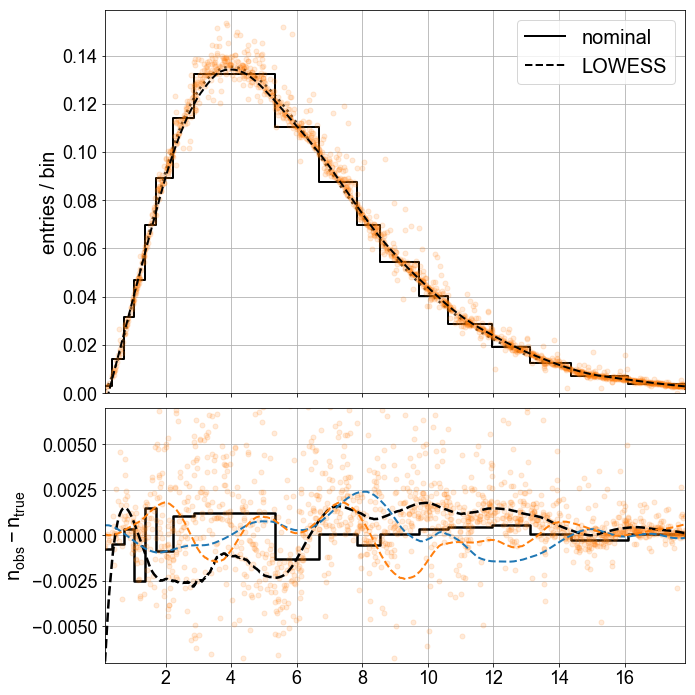

In [24]:
# plot the function and its up and down variants
fig, axes = plt.subplots(2, 1, figsize=(10, 10), facecolor='white', sharex=True, gridspec_kw={'height_ratios': [3, 2]})
fig.subplots_adjust(hspace=0)

ax = axes[0]
dxbin = bins[1:] - bins[:-1]
ax.plot(x, func(x, scale), 'k:', alpha=0.8)
ax.plot(bins[:-1], h_nom, linewidth=2, color='k', drawstyle='steps-post', label='nominal')

# random binning
nsamples = 100
rnums = (xmax - xmin)*np.random.rand(nsamples*bins.size).reshape(nsamples, bins.size)
rnums.sort(axis=1)
hists = []
hists_up = []
hists_down = []
htrue = []
xbins = []
for rbins in rnums:
    h, _      = np.histogram(toy_data_nom, rbins, density=True)
    h_up, _   = np.histogram(toy_data_up, rbins, density=True)
    h_down, _ = np.histogram(toy_data_down, rbins, density=True)
    xbin = (rbins[1:] + rbins[:-1])/2
    dxbin = rbins[1:] - rbins[:-1]
    xbins.append(xbin)
    hists.append(h)
    hists_up.append(h_up - h)
    hists_down.append(h_down - h)
    htrue.append(func(xbin, scale))
    
xbins, hists, htrue = np.array(xbins), np.array(hists), np.array(htrue)
hists_up, hists_down = np.array(hists_up), np.array(hists_down)
ax.plot(xbins[0:100], hists[0:100], linestyle=':', linewidth=0, marker='o', color='C1', markersize=5, alpha=0.15)

xflat, hflat, hflat_up, hflat_down = xbins.flatten(), hists.flatten(), hists_up.flatten(), hists_down.flatten()
hflat = [h for _, h in sorted(zip(xflat, hflat))]
hflat_up = [h for _, h in sorted(zip(xflat, hflat_up))]
hflat_down = [h for _, h in sorted(zip(xflat, hflat_down))]
xflat.sort()
h_smooth = lowess(hflat, xflat, frac=0.1, return_sorted=False)
ax.plot(xflat, h_smooth, 'k--', linewidth=2, label='LOWESS')

ax.set_xlim(bins[[0, -2]])
ax.set_ylim(0, 1.2*h_nom.max())
ax.set_ylabel('entries / bin')
#ax.set_title('toy example')
ax.legend()
ax.grid()

ax = axes[1]
xbin = (bins[:-1] + bins[1:])/2
dxbin = bins[1:] - bins[:-1]
ax.plot(bins[:-1], h_nom - h_nom_true, drawstyle='steps-post', color='k', linestyle='-')
diff = hists - htrue
ax.plot(xbins[0:100], diff[0:100], linestyle=':', linewidth=0, marker='o', color='C1', markersize=5, alpha=0.15)
ax.plot(xflat, h_smooth - func(xflat, scale), color='k', linestyle='--')

hflat_up = lowess(hflat_up, xflat, frac=0.1, return_sorted=False)
ax.plot(xflat, hflat_up - (func(xflat, 1.02*scale) - func(xflat, scale)), 'C0--', linewidth=2, label='LOWESS')
hflat_down = lowess(hflat_down, xflat, frac=0.1, return_sorted=False)
ax.plot(xflat, hflat_down - (func(xflat, 0.98*scale) - func(xflat, scale)), 'C1--', linewidth=2, label='LOWESS')

ax.set_xlim(bins[[0, -2]])
ax.set_ylim(-5*diff.std(), 5*diff.std())
ax.set_ylabel('$n_{obs} - n_{true}$')
ax.set_ylim(-1.5*y_max, 1.5*y_max)
#ax.set_title('toy example')
#ax.legend()
ax.grid()

plt.tight_layout(h_pad=0)
#plt.savefig('plots/stats/toy_example_emorph.pdf')
plt.show()

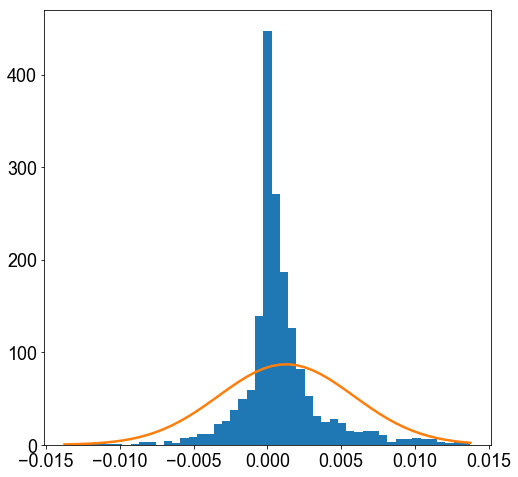

In [25]:
# some statistics for diff
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(8, 8))
from scipy.stats import norm

xbins = np.linspace(-3*diff.std(), 3*diff.std(), 50)
diff = diff.ravel()
h, _, _ = ax.hist(diff, xbins, density=True)
ax.plot(xbins, norm.pdf(xbins, diff.mean(), diff.std()))
plt.show()